# Wind Impact on PID Performance

How robust is the classic cascaded PID architecture to wind? In this notebook, we aim to find that out. We use expert-tuned PID parameters to run an octorotor UAV in a 100x100m square trajectory.

In [1]:
from systems.long_multirotor_sliding_error import LongTrajEnv

from typing import Union, Iterable, List
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm, trange
import optuna

from rl import learn_rl, transform_rl_policy, evaluate_rl, PPO, load_agent
from multirotor.simulation import Multirotor
from multirotor.helpers import DataLog
from multirotor.visualize import plot_datalog
from multirotor.controller import Controller
from multirotor.trajectories import Trajectory, GuidedTrajectory
from multirotor.controller.scurves import SCurveController
from multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, euler_to_angular_rate
from systems.multirotor_sliding_error import MultirotorTrajEnv, VP
from multirotor.controller import (
    AltController, AltRateController,
    PosController, AttController,
    VelController, RateController,
    Controller
)
from scripts.opt_pidcontroller import (
    get_controller, make_disturbance_fn,
    apply_params as apply_params_pid, get_study as get_study_pid
)
from scripts.opt_multirotorenv import apply_params, get_study, get_established_controller

In [2]:
def get_env(wind_ranges, scurve=False, **kwargs):  
    kw = dict(
        safety_radius=5,
        vp=VP,get_controller_fn=lambda m: get_established_controller(m, 15),
        steps_u=50, # RL parameter, does not matter here
        scaling_factor=0.5, # same as above
        wind_ranges=wind_ranges,
        proximity=5,
        seed=0)
    return MultirotorTrajEnv(**kw)

In [3]:
square_np = np.array([[100,0,0], [100,100,0], [0,100,0], [0,0,0]])
square_traj = Trajectory(None, points=square_np, resolution=1000)
square_wpts = square_traj.generate_trajectory(curr_pos=np.array([0,0,0]))

In [4]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / np.linalg.norm(v1)
            ttes.append(tte)
                
        return np.array(ttes)

In [5]:
def toc(tte: np.ndarray): # calculates time outside 5m radius safety corridor
    corridor = 5
    return len(tte[tte > corridor]) / 100

In [6]:
def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [7]:
# runs trajectory with a wind range in the same format as other files:
# [(xmin,xmax), (ymin,ymax), (zmin,zmax)]
def run_trajectory(wind_ranges: np.ndarray): 
    pos_ctrl = []
    vel_ctrl = []
    att_ctrl = []
    rate_ctrl = []
    alt_ctrl = []
    alt_vel_ctrl = []
    ref_orientation = []
    ref_xy = []
    
    env = LongTrajEnv(
        waypoints = square_wpts,
        base_env = get_env(wind_ranges),
        initial_waypoints = square_np,
        random_cardinal_wind=False
    )
    done = False
    env.reset()
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    while not done:
        state, reward, done, info = env.step([0,0,0])
        log.log(reward=reward)
        pos_ctrl.append(log.controller.ctrl_p.state)
        vel_ctrl.append(log.controller.ctrl_v.state)
        att_ctrl.append(log.controller.ctrl_a.state)
        rate_ctrl.append(log.controller.ctrl_r.state)
        alt_ctrl.append(log.controller.ctrl_z.state)
        alt_vel_ctrl.append(log.controller.ctrl_vz.state)
        # ref_orientation.append(log.controller._ref_orientation)
        # ref_xy.append(log.controller._ref_xy)

    log.done_logging()
    pid_states = { # used for finer-grained look into what is happening in PID control. Not returned here for simplicity, but feel free to explore it.
        'pos': np.array(pos_ctrl),
        'vel': np.array(vel_ctrl),
        'att': np.array(att_ctrl),
        'rate': np.array(rate_ctrl),
        'alt': np.array(alt_ctrl),
        'alt_vel': np.array(alt_vel_ctrl),
        # 'ref_orientation': np.array(ref_orientation),
        # 'ref_xy': np.array(ref_xy)
    }
    return log, info, pid_states

In [8]:
wind_range_dict = {
    'zero': [(0,0), (0,0), (0,0)],
    'n5': [(0,0), (5,5), (0,0)],
    'n7': [(0,0), (7,7), (0,0)],
    'n10': [(0,0), (10,10), (0,0)],
    's5': [(0,0), (-5,-5), (0,0)],
    's7': [(0,0), (-7,-7), (0,0)],
    's10': [(0,0), (-10,-10), (0,0)],
    'e5': [(5,5), (0,0), (0,0)],
    'e7': [(7,7), (0,0), (0,0)],
    'e10': [(10,10), (0,0), (0,0)],
    'w5': [(-5,-5), (0,0), (0,0)],
    'w7': [(-7,-7), (0,0), (0,0)],
    'w10': [(-10,-10), (0,0), (0,0)],
    'nw5': [(-3.53553391,-3.53553391), (3.53553391,3.53553391), (0,0)],
    'nw7': [(-4.94974747,-4.94974747), (4.94974747,4.94974747), (0,0)],
    'nw10': [(-7.07106781,-7.07106781), (7.07106781,7.07106781), (0,0)],
    'sw5': [(-3.53553391,-3.53553391), (-3.53553391,-3.53553391), (0,0)],
    'sw7': [(-4.94974747,-4.94974747), (-4.94974747,-4.94974747), (0,0)],
    'sw10': [(-7.07106781,-7.07106781), (-7.07106781,-7.07106781), (0,0)],
    'ne5': [(3.53553391,3.53553391), (3.53553391,3.53553391), (0,0)],
    'ne7': [(4.94974747,4.94974747), (4.94974747,4.94974747), (0,0)],
    'ne10': [(7.07106781,7.07106781), (7.07106781,7.07106781), (0,0)],
    'se5': [(3.53553391,3.53553391), (-3.53553391,-3.53553391), (0,0)],
    'se7': [(4.94974747,4.94974747), (-4.94974747,-4.94974747), (0,0)],
    'se10': [(7.07106781,7.07106781), (-7.07106781,-7.07106781), (0,0)],
}

In [9]:
log, info, pid_states = run_trajectory(wind_ranges=wind_range_dict['zero']) # running an example trajectory to demonstrate its usage
# log, info, pid_states = run_trajectory(wind_ranges=[(0,0), (0,0), (0,0)]) # running an example trajectory to demonstrate its usage

[array([0., 0., 0.]), array([100.,   0.,   0.]), array([100., 100.,   0.]), array([  0., 100.,   0.]), array([0., 0., 0.])]
reached
[0. 1. 0.] [100 100   0]
reached
[-1.  0.  0.] [  0 100   0]
reached
[ 0. -1.  0.] [0 0 0]
reached


Text(0, 0.5, 'Y (m)')

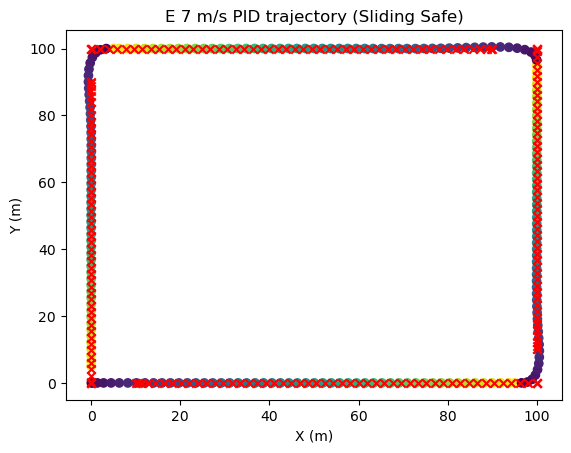

In [10]:
plt.title("E 7 m/s PID trajectory (Sliding Safe)")
plt.scatter(log.x, log.y, c=log.t)
plt.scatter(log.target.position[:,0], log.target.position[:,1], marker='x', color="red")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")

In [14]:
info

{'u': array([2.3040127e+03, 4.5121068e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00], dtype=float32),
 'dxdt': array([ 1.5002e+01,  7.0000e-03, -8.5000e-02,  0.0000e+00,  0.0000e+00,
         7.1320e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=float32),
 'reached': False,
 'outofbounds': True,
 'outoftime': True,
 'tipped': False}

In [13]:
log.target.position

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

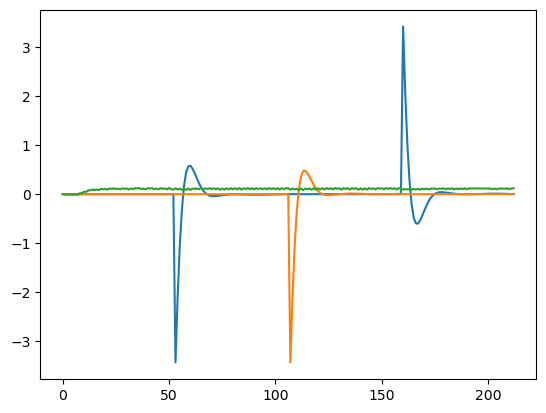

In [12]:
plt.plot(log.states[:,12:15])

In [11]:
np.sum(log.reward)

-162963.5

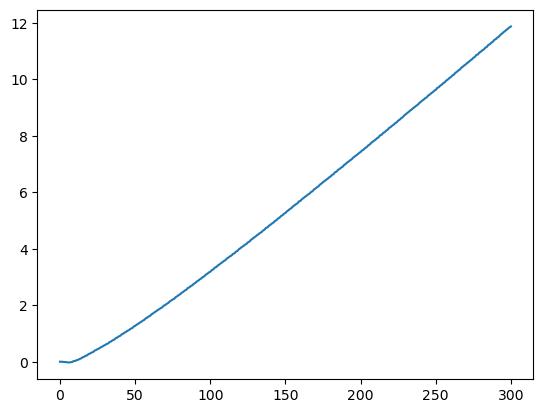

In [12]:
plt.plot(log.z)

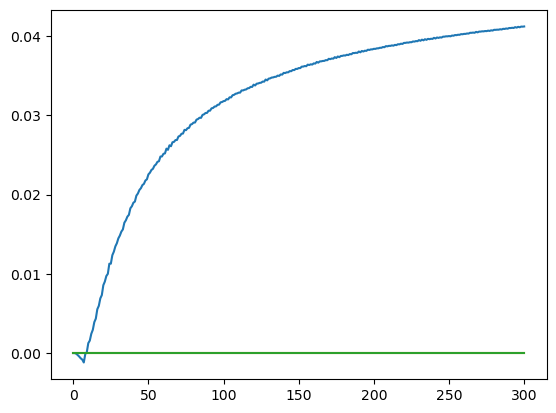

In [13]:
plt.plot(pid_states['alt'])

In [ ]:
plt.plot(log.

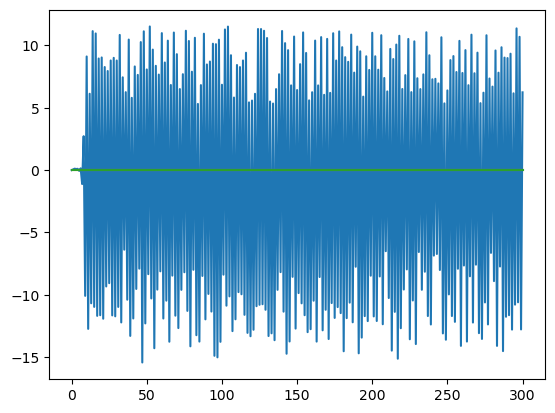

In [55]:
plt.plot(pid_states['alt_vel'])

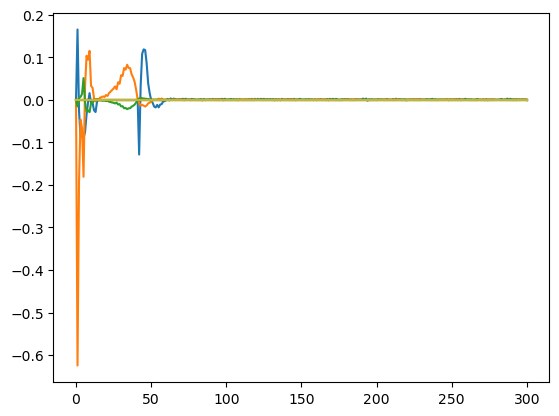

In [52]:
plt.plot(pid_states['rate'])

In [24]:
toc(get_tte(np.array([0,0,0]), log.states[:,12:], log.x, log.y, log.z)) # 2.95 seconds outside corridor

ValueError: operands could not be broadcast together with shapes (9,) (3,) 

In [13]:
wind_results = pd.DataFrame(columns=['Wind', 'Total TTE', 'Mean TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])

In [14]:
# Runs over all winds speeds, saving important metrics
def run_wind_sweep(results, wind_dict):
    for wind in tqdm(wind_dict.keys()):
        log, info = run_trajectory(wind_ranges=wind_dict[wind])
        traj_err = get_tte(np.array([0,0,0]), log.states[:,12:], log.x, log.y, log.z)
        new_result = {
            'Wind': wind,
            'Mean TTE': np.mean(traj_err),
            'Total TTE': np.sum(traj_err),
            'Completed Mission': completed_mission(square_wpts, log.x, log.y, log.z, radius=5),
            'Reward': np.sum(log.reward),
            'Time Outside Corridor': toc(traj_err)
        }
        results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results

In [15]:
wind_results = run_wind_sweep(wind_results, wind_range_dict)

  0%|          | 0/25 [00:00<?, ?it/s]

In [16]:
# wind_results.to_csv('pid_wind.csv') # saves it as CSV, commented out for now so it does not overwrite the other file

In [15]:
wind_results = pd.read_csv('./data/pid_wind.csv')

In [16]:
wind_results

,Unnamed: 0,Wind,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,0,zero,533.379554,6.349757,True,3921.0,0.41
1,1,n5,704.868971,7.342385,True,4241.0,0.35
2,2,n7,1625.867048,15.939873,True,3563.0,0.49
3,3,n10,2378.158524,7.900859,False,-16238.0,2.95
4,4,s5,484.156590,5.695960,True,4361.0,0.32
5,5,s7,534.584855,6.006571,True,4482.0,0.31
6,6,s10,2378.158524,7.900859,False,-16238.0,2.95
7,7,e5,646.851522,7.267995,True,4655.0,0.28
8,8,e7,1757.367841,16.736837,True,3883.0,0.42
9,9,e10,96849.278148,305.518228,False,-14944.0,2.99
